In [ ]:
# Nome:Gustavo Tadeu                         RA:2100566
# Nome:Lucas Morgado                         RA:2101498
# Nome:Aline Holanda                         RA:2101644
# Nome:Leticia Kameoka                       RA:2101490
# Nome:Ludmila Feitosa                       RA:1903126

**1 - Configurando o Spark no Python**

Etapa responsável por realizar o Download e configuração do Apache Spark.

In [ ]:
!ls 
!rm -rf *
#Instacao e configuracao do Java 8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Download do Apache Spark
!wget -q http://apache.osuosl.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
#Descompatacao do Apache Spark
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
#Instalacao do Findspark
!pip install -q findspark

sample_data


**2 - Configurando o Ambiente**

Etapa responsável por configurar o ambiente do Spark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

**3 - Configurando a sessão do Spark**

Etapa responsável por inicializar a sessão do Spark

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

**4 - Validando a Configuração e Versão do Spark**

Etapa de verificação 

In [ ]:
import pyspark
print(pyspark.__version__)

3.1.2


**5 - Download dos Dados **
Etapa responsável por realizar o Download das informações de Gastos por meio de cartão de pagamento providas através da API: http://www.portaltransparencia.gov.br/api-de-dados/cartoes?pagina=1

Ou

CovidTracking através do: https://api.covidtracking.com/

Ou

Casas de Cambio:

https://www3.bcb.gov.br/vet/rest/v2/listaPontoCambio?cnpj=00000000



In [ ]:
!curl -X GET --header 'Accept: application/csv' 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv' > consulta.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.9M  100 24.9M    0     0   102M      0 --:--:-- --:--:-- --:--:--  102M


**6 - Carregando os dados no Spark**

Etapa responsável pela carga de dados no Spark.

In [ ]:
#Instancia o contexto do Spark
sc = spark.sparkContext
#Realiza a leitura da nossa consulta realizada na API do Covid
path = "/content/consulta.csv"
#Declara dataframe df com o conteudo da api que estava no JSON
df = spark.read.option("header",True).csv(path)

**7 - Explorando os dados que foram obtidos**

Etapa de exploração dos dados.

In [ ]:
#Imprime a estrutura de dados do nosso dataframe
df.printSchema()
#Imprime uma amosta de dados ( para especificar as linhas basta colocar a quantidade entre ())
df.show()

root
 |-- iso_code: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- location: string (nullable = true)
 |-- date: string (nullable = true)
 |-- total_cases: string (nullable = true)
 |-- new_cases: string (nullable = true)
 |-- new_cases_smoothed: string (nullable = true)
 |-- total_deaths: string (nullable = true)
 |-- new_deaths: string (nullable = true)
 |-- new_deaths_smoothed: string (nullable = true)
 |-- total_cases_per_million: string (nullable = true)
 |-- new_cases_per_million: string (nullable = true)
 |-- new_cases_smoothed_per_million: string (nullable = true)
 |-- total_deaths_per_million: string (nullable = true)
 |-- new_deaths_per_million: string (nullable = true)
 |-- new_deaths_smoothed_per_million: string (nullable = true)
 |-- reproduction_rate: string (nullable = true)
 |-- icu_patients: string (nullable = true)
 |-- icu_patients_per_million: string (nullable = true)
 |-- hosp_patients: string (nullable = true)
 |-- hosp_patients_per_million

**8 - Analise das informações e resultados obtidos**


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime
#Declara tabela temporaria no SparkSQL
df.createOrReplaceTempView("df")

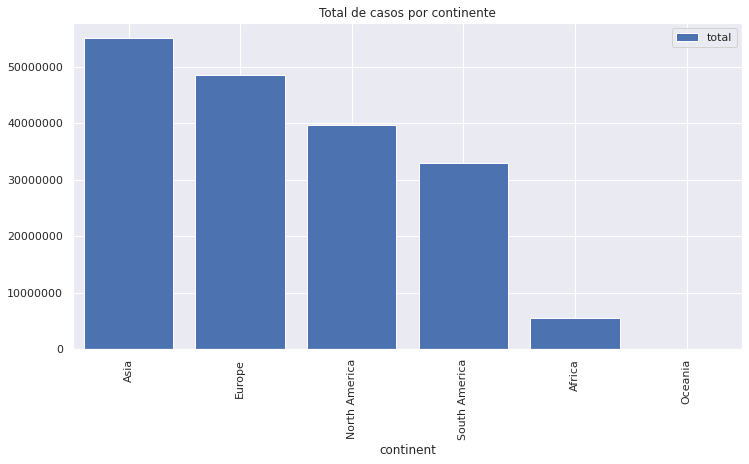

In [44]:
#Total de casos por continente
dfCasesContinent = spark.sql("select continent, cast(sum(new_cases) as int) as total from df where total_cases is not null and continent is not null group by continent order by 2 desc")
dfPandasCasesContinent = dfCasesContinent.select("*").toPandas()
dfPandasCasesContinent.plot(x ='continent', y='total', kind = 'bar',figsize=(12,6))
plt.bar(dfPandasCasesContinent['continent'], dfPandasCasesContinent['total'], align='center')

plt.xticks(dfPandasCasesContinent['continent'])

plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.title('Total de casos por continente')


plt.show()


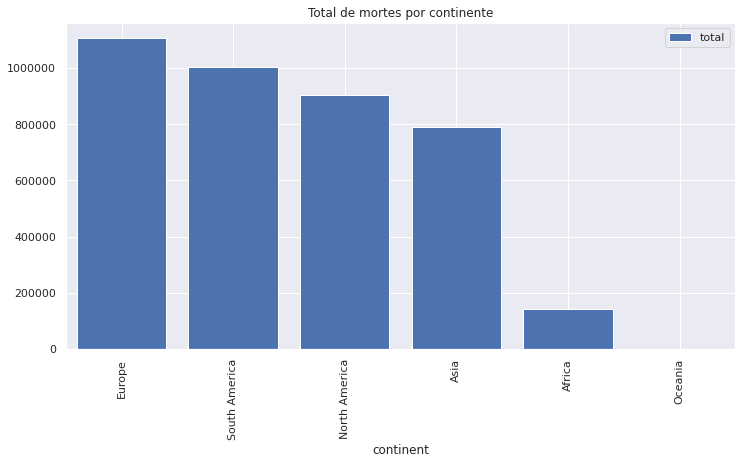

In [41]:
#Total de mortes por continente
dfDeathsContinent = spark.sql("select continent, cast(sum(new_deaths) as int) as total from df where new_deaths is not null and continent is not null group by continent order by 2 desc")
dfPandasDeathsContinent = dfDeathsContinent.select("*").toPandas()
dfPandasDeathsContinent.plot(x ='continent', y='total', kind = 'bar',figsize=(12,6))
plt.bar(dfPandasDeathsContinent['continent'], dfPandasDeathsContinent['total'], align='center')

plt.xticks(dfPandasDeathsContinent['continent'])

plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
#plt.set(xlabel="", ylabel = "Quantidade de mortes")
plt.title('Total de mortes por continente')


plt.show()




Text(0.5, 1.0, 'Total de mortes por mês não acumulado')

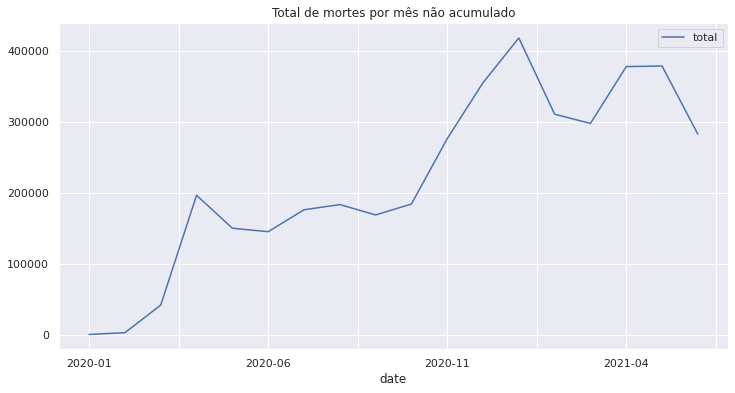

In [47]:
#Total de mortes por mês não acumulado
dfMostDeathsMonth = spark.sql("select substring(date, 1,7) as date,sum(new_deaths)+17 as total  from df where date is not null and new_deaths is not null and continent is not null group by substring(date, 1,7) order by substring(date, 1,7)")
dfPandasMostDeathsMonth = dfMostDeathsMonth.select("*").toPandas()
dfPandasMostDeathsMonth.plot(x ='date', y='total', kind = 'line', figsize=(12,6))
plt.title('Total de mortes por mês não acumulado')




In [ ]:
#Total de mortes geral
dfMostDeathsGeneral = spark.sql("select sum(new_deaths) from df where new_deaths is not null and continent is not null ")
dfPandasMostDeathsGeneral = dfMostDeathsGeneral.select("*").toPandas()
dfPandasMostDeathsGeneral

,sum(CAST(new_deaths AS DOUBLE))
0,3937836.0


Text(0.5, 1.0, 'Top 10 países com mais mortes totais')

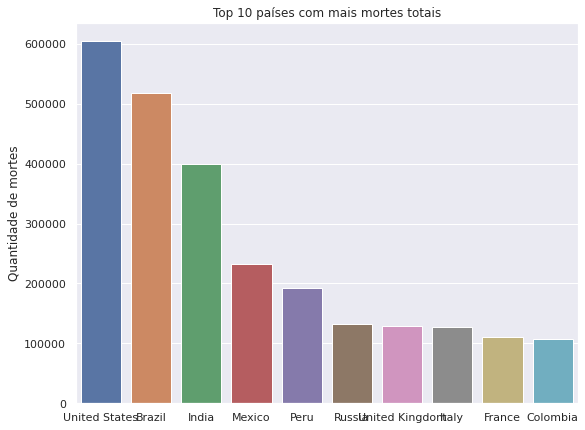

In [50]:
#Top 10 países com mais mortes totais
dfTopLocationDeaths = spark.sql("select location,sum(new_deaths) total from df where new_deaths is not null and continent is not null group by location order by sum(new_deaths) desc limit 10 ")
dfPandasTopLocationDeaths = dfTopLocationDeaths.select("*").toPandas()
dfPandasTopLocationDeaths

import seaborn as sns
sns.set_theme(style="whitegrid")
tips = dfPandasTopLocationDeaths
sns.set(font_scale=1)
plt.figure(figsize=(9, 7))
ax = sns.barplot(x="location", y="total", data=tips)
ax.set(xlabel="", ylabel = "Quantidade de mortes")
plt.title('Top 10 países com mais mortes totais')


